# Import needed libraries

## Import libraries for manipulating the data and statistic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.weightstats import  ttest_ind as t_test
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
import scipy.special as special
import emoji
from math import pi
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from scipy.stats import friedmanchisquare, rankdata, norm
from scipy.special import gammaln
from math import sqrt

## Import libraries for static ploting

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
# some nice colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

# Statring the test and visulize the data

## Load the data for pruning the weights using random expoloration

In [3]:
datafile = "all.csv"
datafileLeNet = "LecunPruningWeights.csv"
df1 = pd.read_csv(datafile)
dfLcun = pd.read_csv(datafileLeNet)
df1

,Dataset,Model,E.Greedy,WSLS,UCB1,KLUCB,BayUCB,OBD,OBS,Thom. Sam,Magnitude,random
0,banknote authentication,0.86,0.86,0.89,0.86,0.86,0.86,0.89,0.87,0.86,4.08,5.98
1,Blood Tra. Service Centre,0.94,0.93,1.05,0.93,0.93,0.93,0.93,0.93,0.93,1.29,0.93
2,Credit Approval,0.97,0.95,0.93,0.93,0.96,0.96,1.98,9.47,1.63,3.40,23.04
3,Haberman's Survival,0.94,0.93,0.94,0.93,0.93,0.93,0.93,0.93,0.93,1.48,1.50
4,Liver Disorders,0.95,0.95,0.96,0.95,0.95,0.95,0.95,1.70,0.95,1.47,1.00
5,MAGIC Gamma Tele.,0.91,0.95,1.17,0.91,0.91,0.91,0.92,0.97,0.91,3.34,1.28
6,Mammographic Mass,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,3.44,0.98
7,MONK's Problems,0.95,0.97,1.14,0.95,0.95,0.95,0.95,6.13,0.95,1.00,0.98
8,Connectionist Bench,0.97,1.14,0.97,0.97,0.97,0.97,0.97,0.97,1.92,1.01,1.01
9,Spambase,0.93,0.95,0.94,0.94,0.94,0.94,0.95,5.22,0.94,2.52,5.86


In [4]:
dfLcun

,Layer,Model,TS Prune half the weights,EG Prune half the weights,UCB1 Prune half the weights
0,FC,0.9906,0.993,0.9908,0.994
1,Conv,0.9906,0.991,0.9907,0.992


## Using Nonparametric tests

I am not sure the data comes from Guassian distribution  and less than 30 sample 

### alternative to paired t-test when data has an ordinary scale or when not
### normally distributed

## Start comparining all pruning algorithms

### Compute friedman test test by ranks between pruning methods

In [5]:
data =  np.stack((df1['Model'], df1['E.Greedy'],df1['WSLS'],df1['UCB1'],
                 df1['KLUCB'],df1['BayUCB'],df1['OBD'],df1['OBS'],
                 df1['Thom. Sam'],df1['Magnitude'],df1['random']))

In [6]:
df_copy = df1.copy()
del df_copy['Dataset']
data =  np.stack([df_copy[col] for col in df_copy.columns])

In [7]:
print(friedmanchisquare(data[0], data[1], data[2], data[3], data[4], data[5], data[6],data[7],
                            data[8],data[9],data[10]))

FriedmanchisquareResult(statistic=63.759803921568682, pvalue=6.9943841457143223e-10)


In [8]:
exec(open("nemopy.py").read())
nemenyi = NemenyiTestPostHoc(data)
meanRanks, pValues = nemenyi.do()

In [9]:
lst = list(df1.columns.values)
lst.remove('Dataset')

In [10]:
len(lst)

11

In [11]:
df1.iloc[1].size

12

In [12]:
q = 3.268003591 # pvalue = 0.05 and number of datasets
#q = 3.029694463 # pvalue = 0.1
N = (df1['Model'].size)
k = (df1.iloc[1].size)-1

In [13]:
CD = q * sqrt(k*(k+1)/(6.0*N))

In [14]:
CD

4.424897779962038

In [15]:
lst

['Model',
 'E.Greedy',
 'WSLS',
 'UCB1',
 'KLUCB',
 'BayUCB',
 'OBD',
 'OBS',
 'Thom. Sam',
 'Magnitude',
 'random']

In [16]:
new_model_pairs = []
for m1,m2 in zip(meanRanks,lst): 
    print('\n',m2, m1, )


 Model 4.625

 E.Greedy 5.625

 WSLS 6.79166666667

 UCB1 3.75

 KLUCB 4.0

 BayUCB 4.0

 OBD 5.25

 OBS 7.70833333333

 Thom. Sam 5.20833333333

 Magnitude 10.0416666667

 random 9.0


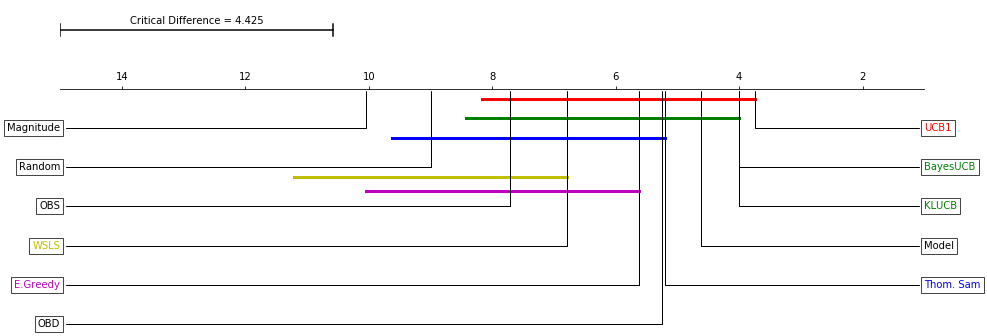

In [17]:
# input data
cd = CD

limits=(15,1)

fig, ax = plt.subplots(figsize=(20,3.6))
plt.subplots_adjust(left=0.2, right=0.8)

# set up plot
ax.set_xlim(limits)
ax.set_ylim(0,1)
ax.spines['top'].set_position(('axes', 0.6))
#ax.xaxis.tick_top()
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_visible(False)
for pos in ["bottom", "left", "right"]:
    ax.spines[pos].set_visible(False)

# CD bar
ax.plot([limits[0],limits[0]-cd], [.9,.9], color="k")
ax.plot([limits[0],limits[0]], [.9-0.03,.9+0.03], color="k")
ax.plot([limits[0]-cd,limits[0]-cd], [.9-0.03,.9+0.03], color="k") 
ax.text(limits[0]-cd/2., 0.92, "Critical Difference = 4.425", ha="center", va="bottom") 

# annotations
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=90")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, va="center")

ax.annotate("OBD", xy=(meanRanks[6], 0.6), xytext=(0,-0.6),ha="right",  **kw, color="k")
ax.annotate("E.Greedy", xy=(meanRanks[1], 0.6), xytext=(0,-0.4),ha="right",  **kw, color="m")
ax.annotate("WSLS", xy=(meanRanks[2], 0.6), xytext=(0,-0.2),ha="right",  **kw, color="y")
ax.annotate("OBS", xy=(meanRanks[7], 0.6), xytext=(0,0),ha="right",  **kw, color="k")
ax.annotate("Random", xy=(meanRanks[10], 0.6), xytext=(0,0.2),ha="right",  **kw, color="k")
ax.annotate("Magnitude", xy=(meanRanks[9], 0.6), xytext=(0,0.4),ha="right",  **kw, color="k")

ax.annotate("Thom. Sam", xy=(meanRanks[8], 0.6), xytext=(1,-0.4),ha="left",  **kw, color="b")
ax.annotate("Model", xy=(meanRanks[0], 0.6), xytext=(1,-0.2),ha="left",  **kw, color="k")
ax.annotate("KLUCB", xy=(meanRanks[4], 0.6), xytext=(1,0),ha="left",  **kw, color="g")
ax.annotate("BayesUCB", xy=(meanRanks[5], 0.6), xytext=(1,0.2),ha="left",  **kw, color="g")
ax.annotate("UCB1", xy=(meanRanks[3], 0.6), xytext=(1,0.4),ha="left",  **kw, color="r")


#bars
ax.plot([meanRanks[3],meanRanks[3]+CD],[0.55,0.55], color="r", lw=3)
ax.plot([meanRanks[5],meanRanks[5]+CD],[0.45,0.45], color="g", lw=3)
ax.plot([meanRanks[8],meanRanks[8]+CD],[0.35,0.35], color="b", lw=3)
ax.plot([meanRanks[2],meanRanks[2]+CD],[0.15,0.15], color="y", lw=3)
ax.plot([meanRanks[1],meanRanks[1]+CD],[0.08,0.08], color="m", lw=3)


plt.show()

# Compute friedman test test by UCB1 ranks between pruning methods

In [18]:
from scipy.stats import mstats
H, pval = mstats.friedmanchisquare(df1['UCB1'], df1['BayUCB'],  df1['OBD'], 
                               df1['OBS'], 
                               df1['Magnitude'])
print("H-statistic:", H)
print("P-Value:", pval)
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

H-statistic: 35.1160220994
P-Value: 4.39727996319e-07
Reject NULL hypothesis - Significant differences exist between groups.


# Compute friedman test test by Thompson Sampling ranks between pruning methods

In [19]:
from scipy.stats import mstats
H, pval = mstats.friedmanchisquare(df1['Thom. Sam'], df1['OBS'],  df1['OBD'], 
                               df1['WSLS'], 
                               df1['Magnitude'])
print("H-statistic:", H)
print("P-Value:", pval)
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

H-statistic: 21.7924528302
P-Value: 0.000220413512575
Reject NULL hypothesis - Significant differences exist between groups.


# Compute friedman test test by Spsilon Greedy and WSLS ranks between pruning methods

In [20]:
from scipy.stats import mstats
H, pval = mstats.friedmanchisquare(df1['E.Greedy'], df1['WSLS'], df1['Magnitude'], df1['OBD'], df1['OBS'])
print("H-statistic:", H)
print("P-Value:", pval)
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

H-statistic: 21.4647887324
P-Value: 0.000256074894131
Reject NULL hypothesis - Significant differences exist between groups.


## Between our method and other methods separately as both are independent

In [21]:
print('UCB vs random Pruning')
H, pval = stats.ranksums(df1['UCB1'], df1['random'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

UCB vs random Pruning
H-statistic:	-3.23316150746
P-value:	0.00122428326443
Reject NULL hypothesis - Significant differences exist between groups.


In [22]:
print('UCB vs Optimal Brain Damage')
H, pval = stats.ranksums(df1['UCB1'], df1['OBD'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

UCB vs Optimal Brain Damage
H-statistic:	-0.606217782649
P-value:	0.544370145857
Accept NULL hypothesis - No significant difference between groups.


In [23]:
print('UCB vs Optimal Brain Surgeon')
H, pval = stats.ranksums(df1['UCB1'], df1['OBS'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

UCB vs Optimal Brain Surgeon
H-statistic:	-2.02072594216
P-value:	0.0433081428108
Reject NULL hypothesis - Significant differences exist between groups.


In [24]:
print('UCB vs Deep Compression')
H, pval = stats.ranksums(df1['UCB1'], df1['Magnitude'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

UCB vs Deep Compression
H-statistic:	-4.15692193817
P-value:	3.22564145624e-05
Reject NULL hypothesis - Significant differences exist between groups.


## ranksums test between KLUCB and other pruning methods.

In [25]:
print('KLUCB vs random Pruning')
H, pval = stats.ranksums(df1['KLUCB'], df1['random'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

KLUCB vs random Pruning
H-statistic:	-3.204293994
P-value:	0.00135394144309
Reject NULL hypothesis - Significant differences exist between groups.


In [26]:
print('KLUCB vs Optimal Brain Damage')
H, pval = stats.ranksums(df1['KLUCB'], df1['OBD'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

KLUCB vs Optimal Brain Damage
H-statistic:	-0.317542648054
P-value:	0.750831884089
Accept NULL hypothesis - No significant difference between groups.


In [27]:
print('KLUCB vs Optimal Brain Surgeon')
H, pval = stats.ranksums(df1['KLUCB'], df1['OBS'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

KLUCB vs Optimal Brain Surgeon
H-statistic:	-1.90525588833
P-value:	0.0567468164894
Accept NULL hypothesis - No significant difference between groups.


In [28]:
print('KLUCB vs Deep Compression')
H, pval = stats.ranksums(df1['KLUCB'], df1['Magnitude'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

KLUCB vs Deep Compression
H-statistic:	-4.15692193817
P-value:	3.22564145624e-05
Reject NULL hypothesis - Significant differences exist between groups.


## ranksums test between BayUCB and other pruning methods.

In [29]:
print('BayUCB vs random Pruning')
H, pval = stats.ranksums(df1['BayUCB'], df1['random'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

BayUCB vs random Pruning
H-statistic:	-3.204293994
P-value:	0.00135394144309
Reject NULL hypothesis - Significant differences exist between groups.


In [30]:
print('BayUCB vs Optimal Brain Damage')
H, pval = stats.ranksums(df1['BayUCB'], df1['OBD'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

BayUCB vs Optimal Brain Damage
H-statistic:	-0.317542648054
P-value:	0.750831884089
Accept NULL hypothesis - No significant difference between groups.


In [31]:
print('BayUCB vs Optimal Brain Surgeon')
H, pval = stats.ranksums(df1['BayUCB'], df1['OBS'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

BayUCB vs Optimal Brain Surgeon
H-statistic:	-1.90525588833
P-value:	0.0567468164894
Accept NULL hypothesis - No significant difference between groups.


In [32]:
print('BayUCB vs Deep Compression')
H, pval = stats.ranksums(df1['BayUCB'], df1['Magnitude'])
print ("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
if pval < 0.05:
    print("Reject NULL hypothesis - Significant differences exist between groups.")
if pval > 0.05:
    print("Accept NULL hypothesis - No significant difference between groups.")

BayUCB vs Deep Compression
H-statistic:	-4.15692193817
P-value:	3.22564145624e-05
Reject NULL hypothesis - Significant differences exist between groups.


In [33]:
# Get all models pairs
interstModel = ['BayUCB', 'UCB1', 'KLUCB',
               'E.Greedy', 'WSLS', 'Thom. Sam']
lst = list(df1.columns.values)
lst.remove('Dataset')
model_pairs = []

for m1 in range(len(df1.columns)-2):
    for m2  in range(m1+1,len(df1.columns)-1):
        model_pairs.append((lst[m1], lst[m2]))

pvalueList = []
new_model_pairs = []
for m1, m2 in model_pairs: 
    print('\n',m1, m2)
    pvalue = stats.ranksums(df1[m1], df1[m2])
    #print(pvalue[1])
    if (m1 in interstModel or m2 in interstModel):
        new_model_pairs.append((m1,m2))
        pvalueList.append(pvalue[1])
    print(pvalue)   


 Model E.Greedy
RanksumsResult(statistic=-0.54848275573014438, pvalue=0.58336046670270325)

 Model WSLS
RanksumsResult(statistic=-1.414508159514583, pvalue=0.15721275334000387)

 Model UCB1
RanksumsResult(statistic=0.49074772881118184, pvalue=0.62360488439568895)

 Model KLUCB
RanksumsResult(statistic=0.1732050807568877, pvalue=0.86249023013592163)

 Model BayUCB
RanksumsResult(statistic=0.1732050807568877, pvalue=0.86249023013592163)

 Model OBD
RanksumsResult(statistic=-0.202072594216369, pvalue=0.83985997254000344)

 Model OBS
RanksumsResult(statistic=-1.7609183210283583, pvalue=0.078252228526237047)

 Model Thom. Sam
RanksumsResult(statistic=-0.11547005383792514, pvalue=0.90807255525597519)

 Model Magnitude
RanksumsResult(statistic=-4.1569219381653051, pvalue=3.2256414562437673e-05)

 Model random
RanksumsResult(statistic=-3.1754264805429413, pvalue=0.0014961642897455532)

 E.Greedy WSLS
RanksumsResult(statistic=-1.0392304845413263, pvalue=0.29869755599497017)

 E.Greedy UCB1
Ran

In [34]:
for pair, p in zip(new_model_pairs, pvalueList):
    if p < 0.05:
        print('The pvalue between',pair, 'is', p, '< 0.05 then', 
              emoji.emojize('REJECT the NULL Hypothesis :thumbs_up_sign:'))
    else:
        print('The pvalue between',pair, 'is', p, '> 0.05 then',
              emoji.emojize('FAIL to REJECT the NULL Hypothesis :thumbs_down_sign:'))

The pvalue between ('Model', 'E.Greedy') is 0.583360466703 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'WSLS') is 0.15721275334 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'UCB1') is 0.623604884396 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'KLUCB') is 0.862490230136 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'BayUCB') is 0.862490230136 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'Thom. Sam') is 0.908072555256 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('E.Greedy', 'WSLS') is 0.298697555995 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('E.Greedy', 'UCB1') is 0.312321421676 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('E.Greedy', 'KLUCB') is 0.506720514878 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('E.Greedy', 'BayUCB') i

## Prune LeCun Model

In [35]:
# Get all models pairs
interstModel = ['TS Prune half the weights', 'EG Prune half the weights', 
                'UCB1 Prune half the weights']
lst = list(dfLcun.columns.values)
lst.remove('Layer')
model_pairs = []

for m1 in range(len(dfLcun.columns)-2):
    for m2  in range(m1+1,len(dfLcun.columns)-1):
        model_pairs.append((lst[m1], lst[m2]))

# Conduct t-test on each pair
pvalueList = []
new_model_pairs = []
for m1, m2 in model_pairs: 
    print('\n',m1,'<--- VS --->', m2)
    pvalue = stats.ranksums(dfLcun[m1], dfLcun[m2])
    #print(pvalue[1])
    if (m1 in interstModel or m2 in interstModel):
        new_model_pairs.append((m1,m2))
        pvalueList.append(pvalue[1])
    print(pvalue)   


 Model <--- VS ---> TS Prune half the weights
RanksumsResult(statistic=-1.5491933384829668, pvalue=0.12133525035848211)

 Model <--- VS ---> EG Prune half the weights
RanksumsResult(statistic=-1.5491933384829668, pvalue=0.12133525035848211)

 Model <--- VS ---> UCB1 Prune half the weights
RanksumsResult(statistic=-1.5491933384829668, pvalue=0.12133525035848211)

 TS Prune half the weights <--- VS ---> EG Prune half the weights
RanksumsResult(statistic=1.5491933384829668, pvalue=0.12133525035848211)

 TS Prune half the weights <--- VS ---> UCB1 Prune half the weights
RanksumsResult(statistic=-0.7745966692414834, pvalue=0.43857802608099983)

 EG Prune half the weights <--- VS ---> UCB1 Prune half the weights
RanksumsResult(statistic=-1.5491933384829668, pvalue=0.12133525035848211)


In [36]:
for pair, p in zip(new_model_pairs, pvalueList):
    if p < 0.05:
        print('The pvalue between',pair, 'is', p, '< 0.05 then', 
              emoji.emojize('REJECT the NULL Hypothesis :thumbs_up_sign:'))
    else:
        print('The pvalue between',pair, 'is', p, '> 0.05 then',
              emoji.emojize('FAIL to REJECT the NULL Hypothesis :thumbs_down_sign:'))

The pvalue between ('Model', 'TS Prune half the weights') is 0.121335250358 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'EG Prune half the weights') is 0.121335250358 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('Model', 'UCB1 Prune half the weights') is 0.121335250358 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('TS Prune half the weights', 'EG Prune half the weights') is 0.121335250358 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('TS Prune half the weights', 'UCB1 Prune half the weights') is 0.438578026081 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
The pvalue between ('EG Prune half the weights', 'UCB1 Prune half the weights') is 0.121335250358 > 0.05 then FAIL to REJECT the NULL Hypothesis 👎
